<a href="https://colab.research.google.com/github/simonaertssen/machine-learning-problems/blob/main/Inductive_Bias_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[astroautomata.com/inductive_biases_tutorial.html](https://astroautomata.com/inductive_biases_tutorial.html)


## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. Turn on the GPU with Edit->Notebook settings->Hardware accelerator->GPU
3. Execute the following.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 3, and potentially step 2.

## Tutorial

In this tutorial, we will explore the effect of different inductive biases
on the performance of a neural network for physical systems.

We will consider the following inductive biases:
- Hamiltonian Neural Network and Lagrangian Neural Network
    - As well as soft, rather than hard, constraints for each of these.
- With rotational equivariance
- With translational equivariance
- With permutation equivariance
- (Maybe) With soft constraints instead of hard (PINN-like)


We will be using PyTorch, and the [`torchdyn`](https://github.com/DiffEqML/torchdyn) package ([Poli et al., 2020](https://arxiv.org/abs/2009.09346)), since it has the LNN and HNN modules pre-programmed into a nice object-oriented interface.

The HNN was described in Greydanus et al., 2019 - https://arxiv.org/abs/1906.01563v3.

The LNN, and the LNN with permutation/translational equivariance were described in Cranmer et al., 2020 - https://arxiv.org/abs/2003.04630

A modified HNN for permutation equivariance was described in Sanchez-Gonzalez et al., 2019 - https://arxiv.org/abs/1909.12790. However, the one given here is closer to the "FlatHGN" as described in Cranmer et al., 2020b - https://arxiv.org/abs/2006.11287.

Also see another method for this in Finzi et al., 2020 - https://arxiv.org/abs/2002.12880.

In [ ]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import HTML
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import functools


from collections import namedtuple

# Animations:
try:
    from celluloid import Camera
except ImportError:
    !pip install -q celluloid
    from celluloid import Camera

# Einops:
try:
    import einops as eo
except ImportError:
    !pip install -q einops
    import einops as eo

# Accelerate:
try:
    import accelerate
except ImportError:
    !pip install -q accelerate
    import accelerate

Tensor = torch.Tensor

     |████████████████████████████████| 58 kB 3.9 MB/s 


First, we will create our dynamical system.

Let us consider 3-particle gravitational system. Assume all masses are 1. To generate data, we will create a function that computes the acceleration for any given state.

In [ ]:
zero = 1e-16 # small number to avoid division by zero
G = 1e1 # force weighting

class State():
    """Simulation state."""
    x: torch.Tensor # Cartesian coordinates [..., particle, 2]
    v: torch.Tensor # Cartesian velocities [..., particle, 2]

    def __init__(self, x, v):
        super().__init__()
        self.x = x
        self.v = v
        self.softening = 0.2

    def __repr__(self) -> str:
        return f'State(x={self.x}, v={self.v})'

    def acceleration(self):
        x = self.x
        nparticle = x.shape[-2]

        r_vec = x[..., :, None, :] - x[..., None, :, :]
        r = torch.sqrt(
                torch.sum(r_vec**2, dim=-1, keepdim=True)
                + zero
        ) + zero
        # [..., particle, particle, dim]
        u_vec = r_vec / r
        r_softened = r + self.softening

        a = - G * u_vec / r_softened**2

        # Zero self term
        a[..., torch.eye(nparticle, dtype=torch.bool), :] = 0.0

        # Aggregate accelerations over neighbor particles:
        out = torch.sum(a, dim=-2)

        return out

    def potential(self):
        """Compute the potential energy."""
        x = self.x
        nparticle = x.shape[-2]

        r_vec = x[..., :, None, :] - x[..., None, :, :]
        r = torch.sqrt(
                torch.sum(r_vec**2, dim=-1, keepdim=True)
                + zero
        ) + zero
        # [..., particle, particle]
        r_softened = r + self.softening

        potential_part = - G / r_softened

        # Zero self term
        potential_part[..., torch.eye(nparticle, dtype=torch.bool), :] = 0.0

        # Aggregate potentials:
        out = torch.sum(potential_part, dim=[-3, -2, -1])

        return out

    def kinetic(self):
        """Compute the kinetic energy."""
        v = self.v
        v2 = torch.sum(v**2, dim=-1)
        return 0.5 * torch.sum(v2, dim=-1)

    def update(self, dt=1e-3):
        """Integrate one time step."""
        a = self.acceleration()

        # Leapfrog steps:
        self.x = self.x + self.v * dt + 0.5 * a * dt**2
        a_plus = self.acceleration()
        self.v = self.v + 0.5 * (a + a_plus) * dt

    def plot(self):
        """Plot the current state."""
        x = self.x.cpu().detach().numpy()

        # Flatten first axes:
        x = eo.rearrange(x, '... particle dim -> (...) particle dim')

        # Different color for each particle.
        c = np.arange(x.shape[1])
        c = eo.repeat(c,
                      'particle -> batch particle',
                      batch=x.shape[0])
        plt.scatter(x[..., 0].ravel(),
                    x[..., 1].ravel(),
                    s=50,
                    c=c.ravel())

Next, let's write some code to integrate our system over time:

In [ ]:
def integrate(state, t, accel_function=None, mxstep=0):
    """Integrate using scipy"""
    if accel_function is None:
        accel_function = lambda state: (state.v, state.acceleration())

    y0 = torch.cat((state.x, state.v), dim=-1)
    y0_flat = eo.rearrange(y0, 'batch particle dim2 -> (batch particle dim2)').cpu().detach().numpy()

    def build_state(yt):
        state_vec = eo.rearrange(yt, '(batch particle dim2) -> batch particle dim2',
                         particle=nparticle, dim2=4
        )
        x = torch.tensor(state_vec[..., :2])
        v = torch.tensor(state_vec[..., 2:])
        state = State(x=x, v=v)
        return state

    def update(yt, *args):
        state = build_state(yt)
        v, a = accel_function(state)
        return eo.rearrange(
            torch.cat((v, a), dim=-1),
            'batch particle dim2 -> (batch particle dim2)',
        ).cpu().detach().numpy()

    all_yt = odeint(update, y0_flat, t, atol=1e-3, rtol=1e-3,
                    mxstep=mxstep)
    return [build_state(yt) for yt in all_yt]


Let's test this by generating a short movie.

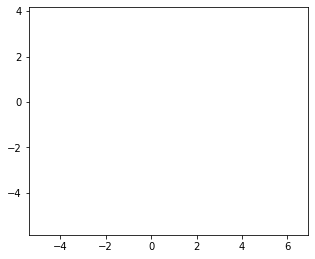

In [ ]:
torch.random.manual_seed(0)

nparticle = 3
nbatch = 1

x = torch.randn(nbatch, nparticle, 2) * 3
# Offset to CoM:
x = x - torch.mean(x, dim=1, keepdim=True)

# Set initial velocity to circular orbit:
v = torch.stack((x[..., 1], -x[..., 0]), dim=2) * 0.05

init_state = State(x=x, v=v)

# Integrate over 20 seconds, and record states:
all_state = integrate(init_state, np.linspace(0, 20, 300))

fig = plt.figure(figsize=(5, 5))
cam = Camera(fig)

for i in range(300):
    state = all_state[i]
    state.plot()
    # Equal aspect ratio:
    plt.gca().set_aspect('equal')
    cam.snap()

ani = cam.animate()
HTML(ani.to_jshtml())

Let's create a data-generating function for training:

In [ ]:
def gen_data(seed=0, nbatch=1, nparticle=3, device='cpu'):
    x = torch.randn(nbatch, nparticle, 2, device=device) * 3
    v = torch.randn(nbatch, nparticle, 2, device=device) * 0.15

    init_state = State(x=x, v=v)
    a = init_state.acceleration()

    return (x, v, a)

This is cheap to generate, so we will call it during training.

In [ ]:
%%shell
# torchdyn requires python 3.8+, so we instead copy the code we need:
curl -s https://raw.githubusercontent.com/DiffEqML/torchdyn/1.0-release/torchdyn/models/energy.py -o torchdyn_models_energy.py > /dev/null

In [ ]:
from torchdyn_models_energy import LNN, HNN

For each of these models, we define a function which computes either the Lagrangian or Hamiltonian. This function can have additional inductive biases in it.

Because HNNs and LNNs are trained with first and second order gradients, respectively, we must use twice-differentiable activations. Here, I use softplus.

In [ ]:
class EnergyModel(nn.Module):
    def __init__(self, dim, nparticles, n_hid=64,
                 activation=nn.Softplus,
                 permutation=False,
                 permutation_translation=False,
                 permutation_translation_rotation=False):
        super().__init__()

        assert (int(permutation) + int(permutation_translation) + int(permutation_translation_rotation) <= 1)

        n_out = 1
        self.dim = dim
        self.nparticles = nparticles

        self.permutation = permutation
        self.permutation_translation = permutation_translation
        self.permutation_translation_rotation = permutation_translation_rotation

        # Note that this would not generalize to larger # of particles, since
        # we sum kinetic energy over pairs as well as potential.
        if permutation:
            # sum(f(vi, xi, xj), j)
            n_in = dim + 2 * dim
        elif permutation_translation:
            # sum(f(vi, xi - xj), j)
            n_in = dim + dim
        elif permutation_translation_rotation:
            # sum(f(|vi|, |xi - xj|), j)
            n_in = 2
        else:
            # f(v1, ..., vn, x1, ..., xn)
            n_in = dim * nparticles * 2

        self.mlp = nn.Sequential(
            nn.Linear(n_in, n_hid), activation(),
            nn.Linear(n_hid, n_hid), activation(),
            nn.Linear(n_hid, n_hid), activation(),
            nn.Linear(n_hid, n_out),
        )

    def forward(self, x):
        # Assumes that data is in the format:
        # x[..., :(half)] = position
        # x[..., (half):] = velocity
        # Then, position is packed in the shape 'batch (particle dim)'.
        # See the einops commands below for unpacking:
        assert len(x.shape) == 2
        nfeatures = x.shape[-1]

        if not (self.permutation or self.permutation_translation or self.permutation_translation_rotation):
            # Feed in all particles concatenated:
            return self.mlp(x)

        x, v = x[..., :nfeatures//2], x[..., nfeatures//2:]
        x = eo.rearrange(x, 'batch (particle dim) -> batch particle dim', dim=self.dim)
        v = eo.rearrange(v, 'batch (particle dim) -> batch particle dim', dim=self.dim)

        # Repeat pairs:
        vi = eo.repeat(v, 'batch i dim -> batch i j dim',
                       j=self.nparticles)
        xi = eo.repeat(x, 'batch i dim -> batch i j dim',
                       j=self.nparticles)
        xj = eo.repeat(x, 'batch j dim -> batch i j dim',
                       i=self.nparticles)

        if self.permutation:
            X = torch.cat((vi, xi, xj), dim=-1)
        elif self.permutation_translation:
            X = torch.cat((vi, xi - xj), dim=-1)
        elif self.permutation_translation_rotation:
            distance = torch.sqrt(((xi - xj)**2).sum(dim=3, keepdim=True) + zero)
            speed = torch.sqrt((vi**2).sum(dim=3, keepdim=True) + zero)
            X = torch.cat((speed, distance), dim=-1)

        energy_ij = self.mlp(X)
        # Zero self-energy:
        inv_energy_mask = torch.eye(self.nparticles,
                                    dtype=torch.bool,
                                    device=X.device)[None, :, :, None]
        energy_mask = torch.logical_not(inv_energy_mask)
        energy_i = torch.sum(energy_ij * energy_mask, dim=2)
        energy = torch.sum(energy_i, dim=1)


        return energy

Due to training with second-order gradients, we need to use a different initialization strategy rather than simply Xavier or Kaiming initialization. This was found empirically for LNNs, and is given below.

In [ ]:
def custom_init_lnn(net):
    """Custom LNN weight initialization."""
    number_layers = 0
    for name, p in net.named_parameters():
        number_layers = max(number_layers, int(name.split('.')[0]))

    for name, p in net.named_parameters():
        if 'bias' in name:
            # Zero init bias:
            p.data.copy_(torch.zeros_like(p).data)
        elif 'weight' in name:
            # Number of connections:
            n = max(p.shape)
            # Layer num:
            i = int(name.split('.')[0])

            first = int(i == 0)
            last = int(i == number_layers - 1)
            mid = int((i != 0) * (i != number_layers - 1))
            mid *= i

            std = 1.0/np.sqrt(n)
            std *= 2.2*first + 0.58*mid + n*last

            if std == 0:
                raise NotImplementedError("Wrong dimensions for MLP")

            new_p = torch.randn_like(p) * std
            p.data.copy_(new_p.data)

    return net

For training, we will use the package `accelerate` by hugging face: https://github.com/huggingface/accelerate, which has a minimal API for using GPUs.



In [ ]:
def training_problem(
        nparticles,
        total_steps = 10000,
        use_lnn = False, # hnn otherwise
        permutation = False,
        permutation_translation = False,
        permutation_translation_rotation = False,
        n_hid=128,
    ):


    nbatch = 32
    
    net = EnergyModel(dim=2, nparticles=nparticles,
                      n_hid=n_hid,
                      activation=nn.Softplus,
                      permutation=permutation,
                      permutation_translation=permutation_translation,
                      permutation_translation_rotation=permutation_translation_rotation)

    if use_lnn:
        net = custom_init_lnn(net)

    model = LNN(net) if use_lnn else HNN(net)
    opt = optim.Adam(model.parameters(), lr=1e-3)
    # Fast at start, cosine decay at end:
    sched = optim.lr_scheduler.OneCycleLR(opt, 1e-3, total_steps=total_steps)

    acc = accelerate.Accelerator()
    model, opt, sched = acc.prepare(model, opt, sched)

    data_gen = functools.partial(gen_data, nbatch=nbatch, nparticle=nparticles)

    return model, opt, sched, acc, data_gen

Note that LNNs are currently very slow in PyTorch until https://github.com/pytorch/functorch is merged into torch. For training with them in practice, one should use functorch or JAX.

See https://github.com/MilesCranmer/lagrangian_nns for a JAX implementation.

Types of symmetries considered:

Time symmetry:
$$ H(x_1, \ldots, x_n, v_1, \ldots, v_n) (\Rightarrow \dot{v_i}=-\nabla_{x_i}H)$$

Plus permutation symmetry:
$$ \sum_i \sum_{i\neq j} H(v_i, x_i, x_j)$$

Plus translational symmetry:
$$ \sum_i \sum_{i\neq j} H(v_i, x_i - x_j)$$

Plus rotational symmetry:
$$ \sum_i \sum_{i\neq j} H(|v_i|, |x_i - x_j|)$$


Note that, even though we have written down these symmetries as *invariances*, both HNNs and LNNs
turn these into *equivariances* via application of the gradient!

In [ ]:
nparticles = 3
total_steps = 20000
use_lnn = False
model, opt, sched, acc, data_gen = training_problem(
                                          nparticles=nparticles,
                                          use_lnn=use_lnn,
                                          total_steps=total_steps,
                                        #   permutation=True,
                                        #   permutation_translation=True,
                                          permutation_translation_rotation=True,
)

In [ ]:
losses = []
from tqdm.auto import trange
print_every = 300
use_hnn = not use_lnn
for step in trange(total_steps):
    opt.zero_grad()

    (x, v, a) = data_gen(device=acc.device)

    x = eo.rearrange(x, 'batch particle dim -> batch (particle dim)')
    v = eo.rearrange(v, 'batch particle dim -> batch (particle dim)')
    a = eo.rearrange(a, 'batch particle dim -> batch (particle dim)')

    X = torch.cat((x, v), dim=-1)

    out = model(X)
    pred_v = out[..., :nparticles * 2]
    pred_a = out[..., nparticles * 2:]

    a_loss = F.mse_loss(pred_a, a)
    loss = a_loss

    if use_hnn:
        v_loss = F.mse_loss(pred_v, v) 
        loss += v_loss

    acc.backward(loss)
    opt.step()
    sched.step()

    losses.append(a_loss.item())

    if step % print_every == 0 and step > 0:
        # Show median loss:
        print(np.median(losses[-print_every:]))

  0%|          | 0/20000 [00:00<?, ?it/s]

6.434059381484985
3.401582956314087
0.5243380069732666
0.16280034184455872
0.10988405719399452
0.08502113446593285
0.09678474441170692
0.0638844482600689
0.05094282329082489
0.0195565577596426
0.07157357782125473
0.15559592097997665
0.11857318133115768
0.04281257279217243
0.10563231259584427
0.03844048082828522
0.01450083963572979
0.17446322739124298
0.0446203351020813
0.016745890490710735
0.043211620301008224
0.18961267173290253
0.03779471665620804
0.03427874483168125
0.02572730928659439
0.03874833323061466
0.019057467579841614
0.05467679910361767
0.03156914561986923
0.00931896036490798
0.060861555859446526
0.04258418828248978
0.01065114513039589
0.024379193782806396
0.009788316674530506
0.008282989263534546
0.02232551760971546
0.011098860763013363
0.00842773774638772
0.01502471650019288
0.008999677374958992
0.012899411842226982
0.0054873761255294085
0.0037501369370147586
0.005743938963860273
0.0027642237255349755
0.003500363673083484
0.002269869204610586
0.007678336231037974
0.002876

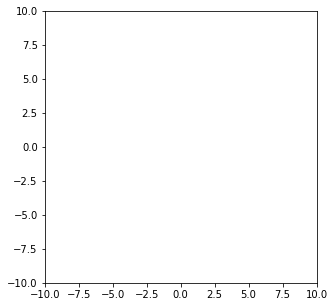

In [ ]:
# Now, we seek to visualize the output of our model over a rollout.

torch.random.manual_seed(0)

nparticle = 3
nbatch = 1

x = torch.randn(nbatch, nparticle, 2) * 3
# Offset to CoM:
x = x - torch.mean(x, dim=1, keepdim=True)

# Set initial velocity to circular orbit:
v = torch.stack((x[..., 1], -x[..., 0]), dim=2) * 0.05

init_state = State(x=x, v=v)

def custom_accel_function(state):
    x = eo.rearrange(state.x, 'batch particle dim -> batch (particle dim)')
    split_point = x.shape[-1]
    v = eo.rearrange(state.v, 'batch particle dim -> batch (particle dim)')
    inp = torch.cat((x, v), dim=-1).to(acc.device).float()
    out = model(inp)
    new_v = eo.rearrange(out[..., :split_point], 'batch (particle dim) -> batch particle dim', dim=2)
    new_a = eo.rearrange(out[..., split_point:], 'batch (particle dim) -> batch particle dim', dim=2)
    return new_v, new_a

# Integrate over 20 seconds, and record states:
all_state = integrate(init_state, np.linspace(0, 10, 100),
                      accel_function=custom_accel_function, mxstep=100)

fig = plt.figure(figsize=(5, 5))
cam = Camera(fig)

for i in range(100):
    state = all_state[i]
    state.plot()
    # Equal aspect ratio:
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.gca().set_aspect('equal')
    cam.snap()

ani = cam.animate()
HTML(ani.to_jshtml())